# Module 04: Unsupervised Learning (Assignment 2-B)

In this assignment, we are supposed to apply Gaussian Mixture Models and Affinity Propagation algorithms on Online Retail data set to identify the different clusters present in the data. EDA on this data sets has been performed in assignment 1.

In [1]:
# importing relevant libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Online Retail Dataset

In [2]:
# reading the dataset in python notebook
df=pd.read_csv('Online_Retail.csv', encoding="ISO-8859–1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-10 8:26,3.39,17850.0,United Kingdom


#### 1. Data Cleaning

In [3]:
# change the invoice_date format - String to Timestamp format
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate)

In [4]:
# missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# dropping missing values
df1 = df.dropna()

In [6]:
df1.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,406829,406829,406829,406829.000000,406829,406829.000000,406829.000000,406829
unique,22190,3684,3896,NaN,20460,NaN,NaN,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom
freq,542,2077,2070,NaN,543,NaN,NaN,361878
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.061303,NaN,3.460471,15287.690570,NaN
std,NaN,NaN,NaN,248.693370,NaN,69.315162,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,0.000000,12346.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13953.000000,NaN


In [7]:
# change customer ID format - Float to Int type
df1['CustomerID'] = df1['CustomerID'].astype('int64')

<ipython-input-7-bd561e096772>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['CustomerID'] = df1['CustomerID'].astype('int64')


In [8]:
# Removing negative quatities from dataset
df1 = df1[df1.Quantity > 0]

In [9]:
#creating amount spent column from quantity and unitprice column
df1['AmountSpent'] = df1['Quantity'] * df1['UnitPrice']

# creating year, month, day and hour columns from Invoice Date
df1['year_month'] = df1['InvoiceDate'].map(lambda x: 100*x.year + x.month) 
df1['month'] = df1['InvoiceDate'].dt.month
df1['day'] = df1['InvoiceDate'].dt.dayofweek
df1['hour'] = df1['InvoiceDate'].dt.hour

In [10]:
# rearranging all columns for better reference
df1 = df1[['CustomerID','InvoiceNo','InvoiceDate','year_month','month','day','hour','StockCode',
                 'Description','Quantity','UnitPrice','AmountSpent','Country']]

df1.head()

,CustomerID,InvoiceNo,InvoiceDate,year_month,month,day,hour,StockCode,Description,Quantity,UnitPrice,AmountSpent,Country
0,17850,536365,2010-12-01 08:26:00,201012,12,2,8,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,15.30,United Kingdom
1,17850,536365,2010-12-01 08:26:00,201012,12,2,8,71053,WHITE METAL LANTERN,6,3.39,20.34,United Kingdom
2,17850,536365,2010-12-01 08:26:00,201012,12,2,8,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,22.00,United Kingdom
3,17850,536365,2010-12-01 08:26:00,201012,12,2,8,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,20.34,United Kingdom
4,17850,536365,2010-12-01 08:26:00,201012,12,2,8,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,20.34,United Kingdom


#### 2. Data Preparation for Model

In [11]:
# Removing free orders
df_paid = df1[df1.AmountSpent != 0]

##### Monetary

In [12]:
monetary = df_paid.groupby("CustomerID").AmountSpent.sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,AmountSpent
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


##### Frequency

In [13]:
frequency = df_paid.groupby("CustomerID").InvoiceNo.count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17


##### Recency

In [14]:
max_date = max(df_paid.InvoiceDate)
max_date = max_date + pd.DateOffset(days = 1)

df_paid['Diff'] = max_date - df_paid['InvoiceDate']

recency = df_paid.groupby('CustomerID')['Diff'].min()
recency = recency.reset_index()
recency['Diff'] = recency['Diff'].dt.days
recency.head()

<ipython-input-14-5643a7a3274d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paid['Diff'] = max_date - df_paid['InvoiceDate']


,CustomerID,Diff
0,12346,326
1,12347,2
2,12348,75
3,12349,19
4,12350,310


In [15]:
df_cluster = pd.DataFrame()
df_cluster['Recency'] = recency['Diff']
df_cluster['Frequency'] = frequency['InvoiceNo']
df_cluster['Monetary'] = monetary['AmountSpent']
df_cluster.head()

,Recency,Frequency,Monetary
0,326,1,77183.60
1,2,182,4310.00
2,75,31,1797.24
3,19,73,1757.55
4,310,17,334.40


In [16]:
# Logarithmic tranformation of clusters to remove skewedness
df_cluster_log = np.log(df_cluster[['Recency', 'Frequency','Monetary']])
df_cluster_log.head()

,Recency,Frequency,Monetary
0,5.786897,0.000000,11.253942
1,0.693147,5.204007,8.368693
2,4.317488,3.433987,7.494007
3,2.944439,4.290459,7.471676
4,5.736572,2.833213,5.812338


#### 3. Clustering algorithms

In this section, I will apply Gaussian Mixture Models and Affinity Propagation algorithms to identify different clusters present in Online Retail data set.

#### i) Gaussian Mixture Model

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(df_cluster_log)

In [18]:
from sklearn.mixture import GaussianMixture
X_train = cluster_scaled

In [19]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X_train)


print(gmm.means_)
print('\n')
print(gmm.covariances_)

[[ 0.94170236 -0.64856126 -0.43495649]
 [-0.630006    0.34546935  0.24797808]
 [ 0.20595958 -0.03397504 -0.04265786]]


[[[ 0.16616222 -0.0759675  -0.13932195]
  [-0.0759675   0.92106524  0.35298953]
  [-0.13932195  0.35298953  0.71340366]]

 [[ 0.86291806 -0.31110187 -0.41463279]
  [-0.31110187  1.03895714  0.82209614]
  [-0.41463279  0.82209614  1.22159013]]

 [[ 0.60896507 -0.30567254 -0.33061373]
  [-0.30567254  0.60157731  0.64375545]
  [-0.33061373  0.64375545  0.71103238]]]


 Guassian Mixture Models
 Silhoutte Score: 0.027
 Davies-Bouldin Score: 2.24
 Calinski-Harabasz Score: 703.067
 Number of clusters: 3


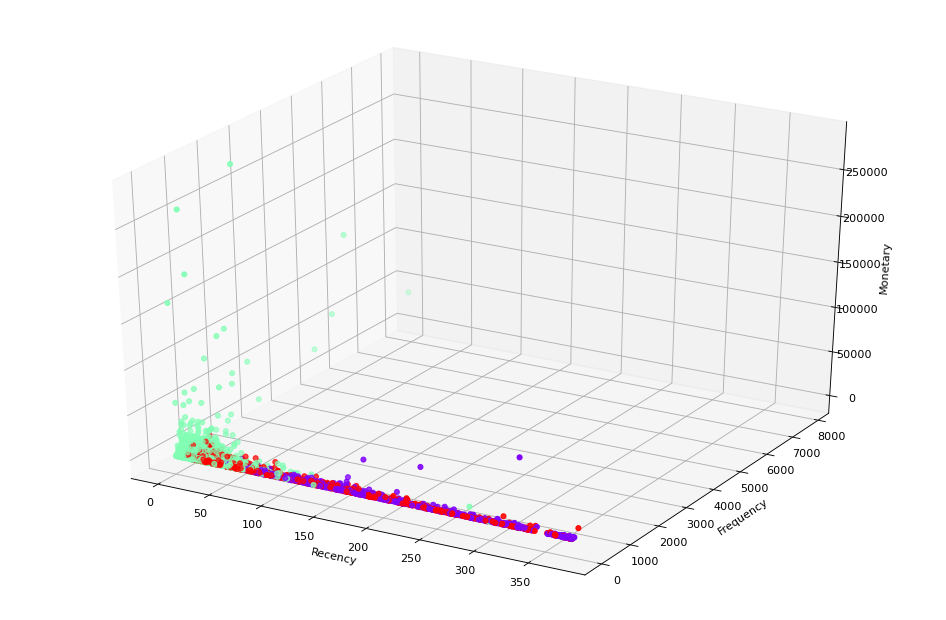

In [20]:
from sklearn import metrics
labels = gmm.predict(X_train)
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(df_cluster['Recency'],df_cluster['Frequency'],df_cluster['Monetary'],c=labels, cmap='rainbow')

xLabel = ax.set_xlabel('Recency', linespacing=3.2)
yLabel = ax.set_ylabel('Frequency', linespacing=3.1)
zLabel = ax.set_zlabel('Monetary', linespacing=3.4)

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
Si=metrics.silhouette_score(X_train, labels, metric='euclidean').round(3)
DB=metrics.davies_bouldin_score(X_train, labels).round(3)
CH=metrics.calinski_harabasz_score(X_train, labels).round(3)

print(" Guassian Mixture Models")
print(" Silhoutte Score:",Si)
print(" Davies-Bouldin Score:",DB)
print(" Calinski-Harabasz Score:",CH)
print(" Number of clusters:",n_clusters_)

In [21]:
df_clustered_hac = df_cluster.assign(Cluster=labels)
grouped_hac = df_clustered_hac.groupby(['Cluster']).mean().round(1)
grouped_hac

,Recency,Frequency,Monetary
Cluster,,,
0,203.1,31.1,901.8
1,24.0,157.7,3670.5
2,103.9,59.7,1117.3


#### GMM algorithm with different hyper parameters

In [22]:
# Guassian Mixture Models (n_components=2, covariance_type='full')
gmm1 = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm1.fit(X_train)
labels1 = gmm1.predict(X_train)

labels_unique = np.unique(labels1)
n_clusters_1 = len(labels_unique)
Si_1=metrics.silhouette_score(X_train, labels1, metric='euclidean').round(3)
DB_1=metrics.davies_bouldin_score(X_train, labels1).round(3)
CH_1=metrics.calinski_harabasz_score(X_train, labels1).round(3)

print(" Guassian Mixture Models (n_components=2, covariance_type='full')")
print('\n')
print(" Silhoutte Score:",Si_1)
print(" Davies-Bouldin Score:",DB_1)
print(" Calinski-Harabasz Score:",CH_1)
print(" Number of clusters:",n_clusters_1)

 Guassian Mixture Models (n_components=2, covariance_type='full')


 Silhoutte Score: 0.266
 Davies-Bouldin Score: 1.27
 Calinski-Harabasz Score: 1865.101
 Number of clusters: 2


In [23]:
# Guassian Mixture Models (n_components=2, covariance_type='tied')
gmm2 = GaussianMixture(n_components=2, covariance_type='tied', random_state=42)
gmm2.fit(X_train)
labels2 = gmm2.predict(X_train)

labels_unique = np.unique(labels2)
n_clusters_2 = len(labels_unique)
Si_2=metrics.silhouette_score(X_train, labels2, metric='euclidean').round(3)
DB_2=metrics.davies_bouldin_score(X_train, labels2).round(3)
CH_2=metrics.calinski_harabasz_score(X_train, labels2).round(3)

print(" Guassian Mixture Models (n_components=2, covariance_type='tied')")
print('\n')
print(" Silhoutte Score:",Si_2)
print(" Davies-Bouldin Score:",DB_2)
print(" Calinski-Harabasz Score:",CH_2)
print(" Number of clusters:",n_clusters_2)

 Guassian Mixture Models (n_components=2, covariance_type='tied')


 Silhoutte Score: 0.321
 Davies-Bouldin Score: 1.172
 Calinski-Harabasz Score: 1798.862
 Number of clusters: 2


In [24]:
# Guassian Mixture Models (n_components=2, covariance_type='diag')
gmm3 = GaussianMixture(n_components=2, covariance_type='diag', random_state=42)
gmm3.fit(X_train)
labels3 = gmm3.predict(X_train)

labels_unique = np.unique(labels3)
n_clusters_3 = len(labels_unique)
Si_3=metrics.silhouette_score(X_train, labels3, metric='euclidean').round(3)
DB_3=metrics.davies_bouldin_score(X_train, labels3).round(3)
CH_3=metrics.calinski_harabasz_score(X_train, labels3).round(3)

print(" Guassian Mixture Models (n_components=2, covariance_type='diag')")
print('\n')
print(" Silhoutte Score:",Si_3)
print(" Davies-Bouldin Score:",DB_3)
print(" Calinski-Harabasz Score:",CH_3)
print(" Number of clusters:",n_clusters_3)

 Guassian Mixture Models (n_components=2, covariance_type='diag')


 Silhoutte Score: 0.394
 Davies-Bouldin Score: 0.952
 Calinski-Harabasz Score: 3831.583
 Number of clusters: 2


In [25]:
# Guassian Mixture Models (n_components=3, covariance_type='tied')
gmm4 = GaussianMixture(n_components=3, covariance_type='tied', random_state=42)
gmm4.fit(X_train)
labels4 = gmm4.predict(X_train)

labels_unique = np.unique(labels4)
n_clusters_4 = len(labels_unique)
Si_4=metrics.silhouette_score(X_train, labels4, metric='euclidean').round(3)
DB_4=metrics.davies_bouldin_score(X_train, labels4).round(3)
CH_4=metrics.calinski_harabasz_score(X_train, labels4).round(3)

print(" Guassian Mixture Models (n_components=3, covariance_type='tied')")
print('\n')
print(" Silhoutte Score:",Si_4)
print(" Davies-Bouldin Score:",DB_4)
print(" Calinski-Harabasz Score:",CH_4)
print(" Number of clusters:",n_clusters_4)

 Guassian Mixture Models (n_components=3, covariance_type='tied')


 Silhoutte Score: 0.213
 Davies-Bouldin Score: 1.454
 Calinski-Harabasz Score: 1456.752
 Number of clusters: 3


In [26]:
# Guassian Mixture Models (n_components=3, covariance_type='diag')
gmm5 = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
gmm5.fit(X_train)
labels5 = gmm5.predict(X_train)

labels_unique = np.unique(labels5)
n_clusters_5 = len(labels_unique)
Si_5=metrics.silhouette_score(X_train, labels5, metric='euclidean').round(3)
DB_5=metrics.davies_bouldin_score(X_train, labels5).round(3)
CH_5=metrics.calinski_harabasz_score(X_train, labels5).round(3)

print(" Guassian Mixture Models (n_components=3, covariance_type='diag')")
print('\n')
print(" Silhoutte Score:",Si_5)
print(" Davies-Bouldin Score:",DB_5)
print(" Calinski-Harabasz Score:",CH_5)
print(" Number of clusters:",n_clusters_5)

 Guassian Mixture Models (n_components=3, covariance_type='diag')


 Silhoutte Score: 0.287
 Davies-Bouldin Score: 1.138
 Calinski-Harabasz Score: 2939.585
 Number of clusters: 3


In [27]:
# Guassian Mixture Models (n_components=4, covariance_type='full')
gmm6 = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm6.fit(X_train)
labels6 = gmm6.predict(X_train)

labels_unique = np.unique(labels6)
n_clusters_6 = len(labels_unique)
Si_6=metrics.silhouette_score(X_train, labels6, metric='euclidean').round(3)
DB_6=metrics.davies_bouldin_score(X_train, labels6).round(3)
CH_6=metrics.calinski_harabasz_score(X_train, labels6).round(3)

print(" Guassian Mixture Models (n_components=4, covariance_type='full')")
print('\n')
print(" Silhoutte Score:",Si_6)
print(" Davies-Bouldin Score:",DB_6)
print(" Calinski-Harabasz Score:",CH_6)
print(" Number of clusters:",n_clusters_6)

 Guassian Mixture Models (n_components=4, covariance_type='full')


 Silhoutte Score: 0.04
 Davies-Bouldin Score: 2.187
 Calinski-Harabasz Score: 788.728
 Number of clusters: 4


In [28]:
# Guassian Mixture Models (n_components=4, covariance_type='tied')
gmm7 = GaussianMixture(n_components=4, covariance_type='tied', random_state=42)
gmm7.fit(X_train)
labels7 = gmm7.predict(X_train)

labels_unique = np.unique(labels7)
n_clusters_7 = len(labels_unique)
Si_7=metrics.silhouette_score(X_train, labels7, metric='euclidean').round(3)
DB_7=metrics.davies_bouldin_score(X_train, labels7).round(3)
CH_7=metrics.calinski_harabasz_score(X_train, labels7).round(3)

print(" Guassian Mixture Models (n_components=4, covariance_type='tied')")
print('\n')
print(" Silhoutte Score:",Si_7)
print(" Davies-Bouldin Score:",DB_7)
print(" Calinski-Harabasz Score:",CH_7)
print(" Number of clusters:",n_clusters_7)

 Guassian Mixture Models (n_components=4, covariance_type='tied')


 Silhoutte Score: 0.29
 Davies-Bouldin Score: 1.054
 Calinski-Harabasz Score: 2260.788
 Number of clusters: 4


In [29]:
# Guassian Mixture Models (n_components=4, covariance_type='diag')
gmm8 = GaussianMixture(n_components=4, covariance_type='tied', random_state=42)
gmm8.fit(X_train)
labels8 = gmm8.predict(X_train)

labels_unique = np.unique(labels8)
n_clusters_8 = len(labels_unique)
Si_8=metrics.silhouette_score(X_train, labels8, metric='euclidean').round(3)
DB_8=metrics.davies_bouldin_score(X_train, labels8).round(3)
CH_8=metrics.calinski_harabasz_score(X_train, labels8).round(3)

print(" Guassian Mixture Models (n_components=4, covariance_type='diag')")
print('\n')
print(" Silhoutte Score:",Si_8)
print(" Davies-Bouldin Score:",DB_8)
print(" Calinski-Harabasz Score:",CH_8)
print(" Number of clusters:",n_clusters_8)

 Guassian Mixture Models (n_components=4, covariance_type='diag')


 Silhoutte Score: 0.29
 Davies-Bouldin Score: 1.054
 Calinski-Harabasz Score: 2260.788
 Number of clusters: 4


In [30]:
# Guassian Mixture Models (n_components=5, covariance_type='full')
gmm9 = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm9.fit(X_train)
labels9 = gmm9.predict(X_train)

labels_unique = np.unique(labels9)
n_clusters_9 = len(labels_unique)
Si_9=metrics.silhouette_score(X_train, labels9, metric='euclidean').round(3)
DB_9=metrics.davies_bouldin_score(X_train, labels9).round(3)
CH_9=metrics.calinski_harabasz_score(X_train, labels9).round(3)

print(" Guassian Mixture Models (n_components=5, covariance_type='full')")
print('\n')
print(" Silhoutte Score:",Si_9)
print(" Davies-Bouldin Score:",DB_9)
print(" Calinski-Harabasz Score:",CH_9)
print(" Number of clusters:",n_clusters_9)

 Guassian Mixture Models (n_components=5, covariance_type='full')


 Silhoutte Score: 0.092
 Davies-Bouldin Score: 2.406
 Calinski-Harabasz Score: 907.477
 Number of clusters: 5


In [31]:
# Guassian Mixture Models (n_components=5, covariance_type='tied')
gmm10 = GaussianMixture(n_components=5, covariance_type='tied', random_state=42)
gmm10.fit(X_train)
labels10 = gmm10.predict(X_train)

labels_unique = np.unique(labels10)
n_clusters_10 = len(labels_unique)
Si_10=metrics.silhouette_score(X_train, labels10, metric='euclidean').round(3)
DB_10=metrics.davies_bouldin_score(X_train, labels10).round(3)
CH_10=metrics.calinski_harabasz_score(X_train, labels10).round(3)

print(" Guassian Mixture Models (n_components=5, covariance_type='tied')")
print('\n')
print(" Silhoutte Score:",Si_10)
print(" Davies-Bouldin Score:",DB_10)
print(" Calinski-Harabasz Score:",CH_10)
print(" Number of clusters:",n_clusters_10)

 Guassian Mixture Models (n_components=5, covariance_type='tied')


 Silhoutte Score: 0.209
 Davies-Bouldin Score: 1.397
 Calinski-Harabasz Score: 1140.56
 Number of clusters: 5


In [32]:
# Guassian Mixture Models (n_components=5, covariance_type='diag')
gmm11 = GaussianMixture(n_components=5, covariance_type='diag', random_state=42)
gmm11.fit(X_train)
labels11 = gmm11.predict(X_train)

labels_unique = np.unique(labels11)
n_clusters_11 = len(labels_unique)
Si_11=metrics.silhouette_score(X_train, labels11, metric='euclidean').round(3)
DB_11=metrics.davies_bouldin_score(X_train, labels11).round(3)
CH_11=metrics.calinski_harabasz_score(X_train, labels11).round(3)

print(" Guassian Mixture Models (n_components=5, covariance_type='diag')")
print('\n')
print(" Silhoutte Score:",Si_11)
print(" Davies-Bouldin Score:",DB_11)
print(" Calinski-Harabasz Score:",CH_11)
print(" Number of clusters:",n_clusters_11)

 Guassian Mixture Models (n_components=5, covariance_type='diag')


 Silhoutte Score: 0.205
 Davies-Bouldin Score: 1.49
 Calinski-Harabasz Score: 1955.572
 Number of clusters: 5


In [33]:
# Guassian Mixture Models (n_components=6, covariance_type='full')
gmm12 = GaussianMixture(n_components=6, covariance_type='full', random_state=42)
gmm12.fit(X_train)
labels12 = gmm12.predict(X_train)

labels_unique = np.unique(labels12)
n_clusters_12 = len(labels_unique)
Si_12=metrics.silhouette_score(X_train, labels12, metric='euclidean').round(3)
DB_12=metrics.davies_bouldin_score(X_train, labels12).round(3)
CH_12=metrics.calinski_harabasz_score(X_train, labels12).round(3)

print(" Guassian Mixture Models (n_components=6, covariance_type='full')")
print('\n')
print(" Silhoutte Score:",Si_12)
print(" Davies-Bouldin Score:",DB_12)
print(" Calinski-Harabasz Score:",CH_12)
print(" Number of clusters:",n_clusters_12)

 Guassian Mixture Models (n_components=6, covariance_type='full')


 Silhoutte Score: 0.09
 Davies-Bouldin Score: 2.635
 Calinski-Harabasz Score: 717.453
 Number of clusters: 6


In [34]:
# Guassian Mixture Models (n_components=6, covariance_type='diag')
gmm13 = GaussianMixture(n_components=6, covariance_type='diag', random_state=42)
gmm13.fit(X_train)
labels13 = gmm13.predict(X_train)

labels_unique = np.unique(labels13)
n_clusters_13 = len(labels_unique)
Si_13=metrics.silhouette_score(X_train, labels13, metric='euclidean').round(3)
DB_13=metrics.davies_bouldin_score(X_train, labels13).round(3)
CH_13=metrics.calinski_harabasz_score(X_train, labels13).round(3)

print(" Guassian Mixture Models (n_components=6, covariance_type='diag')")
print('\n')
print(" Silhoutte Score:",Si_13)
print(" Davies-Bouldin Score:",DB_13)
print(" Calinski-Harabasz Score:",CH_13)
print(" Number of clusters:",n_clusters_13)

 Guassian Mixture Models (n_components=6, covariance_type='diag')


 Silhoutte Score: 0.234
 Davies-Bouldin Score: 1.226
 Calinski-Harabasz Score: 2028.196
 Number of clusters: 6


In [35]:
# Guassian Mixture Models (n_components=6, covariance_type='tied')
gmm14 = GaussianMixture(n_components=6, covariance_type='tied', random_state=42)
gmm14.fit(X_train)
labels14 = gmm14.predict(X_train)

labels_unique = np.unique(labels14)
n_clusters_14 = len(labels_unique)
Si_14=metrics.silhouette_score(X_train, labels14, metric='euclidean').round(3)
DB_14=metrics.davies_bouldin_score(X_train, labels14).round(3)
CH_14=metrics.calinski_harabasz_score(X_train, labels14).round(3)

print(" Guassian Mixture Models (n_components=6, covariance_type='tied')")
print('\n')
print(" Silhoutte Score:",Si_14)
print(" Davies-Bouldin Score:",DB_14)
print(" Calinski-Harabasz Score:",CH_14)
print(" Number of clusters:",n_clusters_14)

 Guassian Mixture Models (n_components=6, covariance_type='tied')


 Silhoutte Score: 0.176
 Davies-Bouldin Score: 1.318
 Calinski-Harabasz Score: 893.95
 Number of clusters: 6


In [36]:
# Guassian Mixture Models (n_components=7, covariance_type='tied')
gmm15 = GaussianMixture(n_components=7, covariance_type='tied', random_state=42)
gmm15.fit(X_train)
labels15 = gmm15.predict(X_train)

labels_unique = np.unique(labels15)
n_clusters_15 = len(labels_unique)
Si_15=metrics.silhouette_score(X_train, labels15, metric='euclidean').round(3)
DB_15=metrics.davies_bouldin_score(X_train, labels15).round(3)
CH_15=metrics.calinski_harabasz_score(X_train, labels15).round(3)

print(" Guassian Mixture Models (n_components=7, covariance_type='tied')")
print('\n')
print(" Silhoutte Score:",Si_15)
print(" Davies-Bouldin Score:",DB_15)
print(" Calinski-Harabasz Score:",CH_15)
print(" Number of clusters:",n_clusters_15)

 Guassian Mixture Models (n_components=7, covariance_type='tied')


 Silhoutte Score: 0.116
 Davies-Bouldin Score: 1.55
 Calinski-Harabasz Score: 992.184
 Number of clusters: 7


In [37]:
table = pd.DataFrame({'n_components': ['2','2','2','3','3','3','4','4','4','5','5','5','6','6','6','7'], 
                      'covariance_type': ['full','tied','diagonal','full','tied','diagonal','full','tied','diagonal',
                                          'full','tied','diagonal','full','diagonal','tied','tied'], 
                      'No. of Clusters': [n_clusters_1,n_clusters_2,n_clusters_3,n_clusters_,n_clusters_4,n_clusters_5,
                                          n_clusters_6,n_clusters_7,n_clusters_8,n_clusters_9,n_clusters_10,n_clusters_11,
                                         n_clusters_12,n_clusters_13,n_clusters_14,n_clusters_15],
                      'Silhoutte Score': [Si_1,Si_2,Si_3,Si,Si_4,Si_5,Si_6,Si_7,Si_8,Si_9,Si_10,Si_11,Si_12,Si_13,Si_14,Si_15],
                      'Davies-Bouldin Score': [DB_1,DB_2,DB_3,DB,DB_4,DB_5,DB_6,DB_7,DB_8,DB_9,DB_10,DB_11,DB_12,DB_13,DB_14,
                                               DB_15],
                      'Calinski-Harabasz Score': [CH_1,CH_2,CH_3,CH,CH_4,CH_5,CH_6,CH_7,CH_8,CH_9,CH_10,CH_11,CH_12,CH_13,CH_14,
                                               CH_15]})


print('============================== Gaussian Mixture Model Scores With Different Hyper Parameters ==============================')
print('\n')
print("Random State No.:",45)
table

============================== Gaussian Mixture Model Scores With Different Hyper Parameters ==============================


Random State No.: 45


,n_components,covariance_type,No. of Clusters,Silhoutte Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,full,2,0.266,1.270,1865.101
1,2,tied,2,0.321,1.172,1798.862
2,2,diagonal,2,0.394,0.952,3831.583
3,3,full,3,0.027,2.240,703.067
4,3,tied,3,0.213,1.454,1456.752
5,3,diagonal,3,0.287,1.138,2939.585
6,4,full,4,0.040,2.187,788.728
7,4,tied,4,0.290,1.054,2260.788
8,4,diagonal,4,0.290,1.054,2260.788
9,5,full,5,0.092,2.406,907.477


- The table shows validation scores for different GMM hyper parameters
- It is observed that GMM hyper parameters with n_components = 2 and covariance_type = "diagonal" yields best clustering results
- There can be many other combinations of hyper parameters that couldn't be included in the table.

##### GMM Cluster Visualization with best hyper parameter

Gaussian Mixture Model with best hyper parameter


n_components: 2
covariance_type: diagonal
Random State No.: 45
Number of clusters: 2


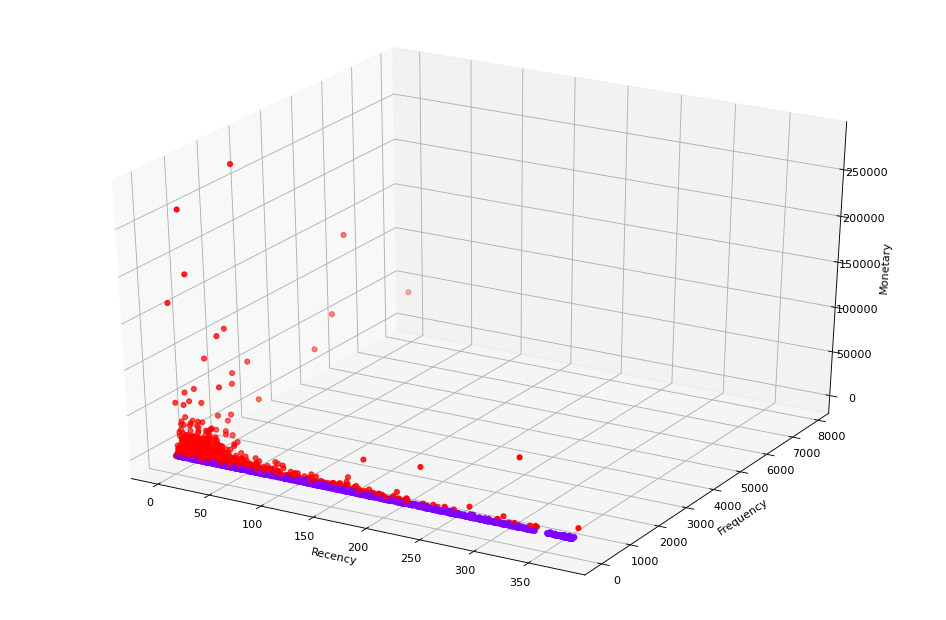

In [38]:
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(df_cluster['Recency'],df_cluster['Frequency'],df_cluster['Monetary'],c=labels3, cmap='rainbow')

xLabel = ax.set_xlabel('Recency', linespacing=3.2)
yLabel = ax.set_ylabel('Frequency', linespacing=3.1)
zLabel = ax.set_zlabel('Monetary', linespacing=3.4)

print("Gaussian Mixture Model with best hyper parameter")
print('\n')
print("n_components:",2)
print("covariance_type: diagonal")
print("Random State No.:",45)
print("Number of clusters:",n_clusters_3)

In [39]:
df_clustered_hac = df_cluster.assign(Cluster=labels3)
grouped_hac1 = df_clustered_hac.groupby(['Cluster']).mean().round(1)
grouped_hac1

,Recency,Frequency,Monetary
Cluster,,,
0,137.8,24.6,436.5
1,34.2,178.2,4139.9


#### ii) Affinity Propagation Algorithm

In [40]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import euclidean_distances
af = AffinityPropagation(random_state=42)
af.fit(cluster_scaled)

AffinityPropagation(random_state=42)

 Affinity Model
 Silhoutte Score: 0.24
 Davies-Bouldin Score: 1.014
 Calinski-Harabasz Score: 1016.448
 Number of clusters: 105


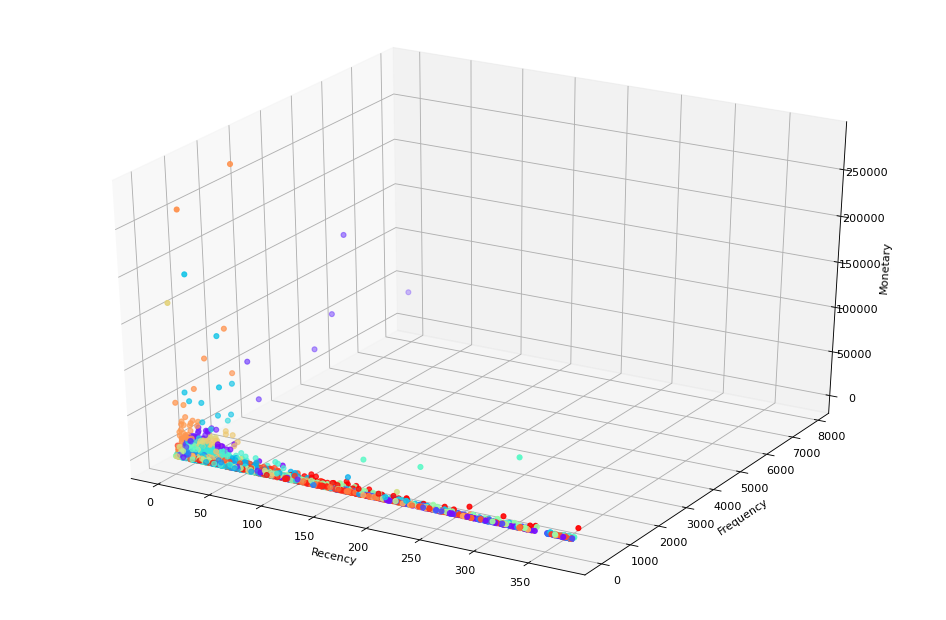

In [41]:
labels = af.predict(cluster_scaled)
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(df_cluster['Recency'],df_cluster['Frequency'],df_cluster['Monetary'],c=labels, cmap='rainbow')

xLabel = ax.set_xlabel('Recency', linespacing=3.2)
yLabel = ax.set_ylabel('Frequency', linespacing=3.1)
zLabel = ax.set_zlabel('Monetary', linespacing=3.4)

labels_unique = np.unique(labels)
n_clusters_ap = len(labels_unique)
Si_ap=metrics.silhouette_score(X_train, labels, metric='euclidean').round(3)
DB_ap=metrics.davies_bouldin_score(X_train, labels).round(3)
CH_ap=metrics.calinski_harabasz_score(X_train, labels).round(3)

print(" Affinity Model")
print(" Silhoutte Score:",Si_ap)
print(" Davies-Bouldin Score:",DB_ap)
print(" Calinski-Harabasz Score:",CH_ap)
print(" Number of clusters:",n_clusters_ap)

In [42]:
df_clustered_hac = df_cluster.assign(Cluster=labels)
grouped_hac = df_clustered_hac.groupby(['Cluster']).mean().round(1)
grouped_hac

,Recency,Frequency,Monetary
Cluster,,,
0,81.0,31.3,552.3
1,40.4,271.8,14153.8
2,289.0,9.4,157.6
3,9.5,12.7,260.1
4,4.7,584.0,11619.6
...,...,...,...
100,117.7,34.5,161.9
101,37.9,32.8,556.3
102,23.3,4.7,682.7


#### AP algorithm with different hyper parameters

In [43]:
# Affinity Propagation (preference=-10,random_state=42)
af1 = AffinityPropagation(preference=-10,random_state=42)
af1.fit(cluster_scaled)
labels1 = af1.predict(cluster_scaled)

labels_unique = np.unique(labels1)
n_clusters_ap1 = len(labels_unique)
Si_ap1=metrics.silhouette_score(cluster_scaled, labels1, metric='euclidean').round(3)
DB_ap1=metrics.davies_bouldin_score(cluster_scaled, labels1).round(3)
CH_ap1=metrics.calinski_harabasz_score(cluster_scaled, labels1).round(3)

print(" Affinity Propagation (preference=-10,random_state=42)")
print('\n')
print(" Silhoutte Score:",Si_ap1)
print(" Davies-Bouldin Score:",DB_ap1)
print(" Calinski-Harabasz Score:",CH_ap1)
print(" Number of clusters:",n_clusters_ap1)

 Affinity Propagation (preference=-10,random_state=42)


 Silhoutte Score: 0.24
 Davies-Bouldin Score: 1.022
 Calinski-Harabasz Score: 1132.878
 Number of clusters: 64


In [44]:
# Affinity Propagation (preference=-9.9,random_state=42)
af2 = AffinityPropagation(preference=-9.9,random_state=42)
af2.fit(cluster_scaled)
labels2 = af2.predict(cluster_scaled)

labels_unique = np.unique(labels2)
n_clusters_ap2 = len(labels_unique)
Si_ap2=metrics.silhouette_score(cluster_scaled, labels2, metric='euclidean').round(3)
DB_ap2=metrics.davies_bouldin_score(cluster_scaled, labels2).round(3)
CH_ap2=metrics.calinski_harabasz_score(cluster_scaled, labels2).round(3)

print(" Affinity Propagation (preference=-9.9,random_state=42)")
print('\n')
print(" Silhoutte Score:",Si_ap2)
print(" Davies-Bouldin Score:",DB_ap2)
print(" Calinski-Harabasz Score:",CH_ap2)
print(" Number of clusters:",n_clusters_ap2)

 Affinity Propagation (preference=-9.9,random_state=42)


 Silhoutte Score: 0.229
 Davies-Bouldin Score: 1.055
 Calinski-Harabasz Score: 1132.213
 Number of clusters: 62


Next I will set a list of preferences based on euclidean distances and use them on affinity propagation algorithm.

In [45]:
preference=euclidean_distances(cluster_scaled, cluster_scaled).max()
preference

11.331504499111663

In [46]:
preference1=euclidean_distances(cluster_scaled, cluster_scaled).mean()
preference1

2.161363050750034

In [47]:
preference2=euclidean_distances(cluster_scaled, cluster_scaled).mean()**2
preference2

4.671490237147495

In [48]:
preference3=preference/2
preference3

5.6657522495558315

In [49]:
preference4=preference3/2
preference4

2.8328761247779157

In [50]:
preference5=preference4/2
preference5

1.4164380623889579

In [51]:
# Affinity Propagation (preference=-2.16,random_state=42)
af3 = AffinityPropagation(preference=-preference1,random_state=42)
af3.fit(cluster_scaled)
labels3 = af3.predict(cluster_scaled)

labels_unique = np.unique(labels3)
n_clusters_ap3 = len(labels_unique)
Si_ap3=metrics.silhouette_score(cluster_scaled, labels3, metric='euclidean').round(3)
DB_ap3=metrics.davies_bouldin_score(cluster_scaled, labels3).round(3)
CH_ap3=metrics.calinski_harabasz_score(cluster_scaled, labels3).round(3)

print(" Affinity Propagation (preference=-2.16,random_state=42)")
print('\n')
print(" Silhoutte Score:",Si_ap3)
print(" Davies-Bouldin Score:",DB_ap3)
print(" Calinski-Harabasz Score:",CH_ap3)
print(" Number of clusters:",n_clusters_ap3)

 Affinity Propagation (preference=-2.16,random_state=42)


 Silhoutte Score: 0.242
 Davies-Bouldin Score: 0.983
 Calinski-Harabasz Score: 940.442
 Number of clusters: 152


In [52]:
# Affinity Propagation (preference=-4.67,random_state=42)
af4 = AffinityPropagation(preference=-preference2,random_state=42)
af4.fit(cluster_scaled)
labels4 = af4.predict(cluster_scaled)

labels_unique = np.unique(labels4)
n_clusters_ap4 = len(labels_unique)
Si_ap4=metrics.silhouette_score(cluster_scaled, labels4, metric='euclidean').round(3)
DB_ap4=metrics.davies_bouldin_score(cluster_scaled, labels4).round(3)
CH_ap4=metrics.calinski_harabasz_score(cluster_scaled, labels4).round(3)

print(" Affinity Propagation (preference=-4.67,random_state=42)")
print('\n')
print(" Silhoutte Score:",Si_ap4)
print(" Davies-Bouldin Score:",DB_ap4)
print(" Calinski-Harabasz Score:",CH_ap4)
print(" Number of clusters:",n_clusters_ap4)

 Affinity Propagation (preference=-4.67,random_state=42)


 Silhoutte Score: 0.243
 Davies-Bouldin Score: 1.012
 Calinski-Harabasz Score: 1037.782
 Number of clusters: 98


In [53]:
# Affinity Propagation (preference=-5.67,random_state=42)
af5 = AffinityPropagation(preference=-preference3,random_state=42)
af5.fit(cluster_scaled)
labels5 = af5.predict(cluster_scaled)

labels_unique = np.unique(labels5)
n_clusters_ap5 = len(labels_unique)
Si_ap5=metrics.silhouette_score(cluster_scaled, labels5, metric='euclidean').round(3)
DB_ap5=metrics.davies_bouldin_score(cluster_scaled, labels5).round(3)
CH_ap5=metrics.calinski_harabasz_score(cluster_scaled, labels5).round(3)

print(" Affinity Propagation (preference=-5.67,random_state=42)")
print('\n')
print(" Silhoutte Score:",Si_ap5)
print(" Davies-Bouldin Score:",DB_ap5)
print(" Calinski-Harabasz Score:",CH_ap5)
print(" Number of clusters:",n_clusters_ap5)

 Affinity Propagation (preference=-5.67,random_state=42)


 Silhoutte Score: 0.239
 Davies-Bouldin Score: 1.001
 Calinski-Harabasz Score: 1045.919
 Number of clusters: 91


In [54]:
# Affinity Propagation (preference=-2.83,random_state=42)
af6 = AffinityPropagation(preference=-preference4,random_state=42)
af6.fit(cluster_scaled)
labels6 = af6.predict(cluster_scaled)

labels_unique = np.unique(labels6)
n_clusters_ap6 = len(labels_unique)
Si_ap6=metrics.silhouette_score(cluster_scaled, labels6, metric='euclidean').round(3)
DB_ap6=metrics.davies_bouldin_score(cluster_scaled, labels6).round(3)
CH_ap6=metrics.calinski_harabasz_score(cluster_scaled, labels6).round(3)

print(" Affinity Propagation (preference=-2.83,random_state=42)")
print('\n')
print(" Silhoutte Score:",Si_ap6)
print(" Davies-Bouldin Score:",DB_ap6)
print(" Calinski-Harabasz Score:",CH_ap6)
print(" Number of clusters:",n_clusters_ap6)

 Affinity Propagation (preference=-2.83,random_state=42)


 Silhoutte Score: 0.241
 Davies-Bouldin Score: 1.002
 Calinski-Harabasz Score: 969.952
 Number of clusters: 130


In [55]:
# Affinity Propagation (preference=-1.42,random_state=42)
af7 = AffinityPropagation(preference=-preference5,random_state=42)
af7.fit(cluster_scaled)
labels7 = af7.predict(cluster_scaled)

labels_unique = np.unique(labels7)
n_clusters_ap7 = len(labels_unique)
Si_ap7=metrics.silhouette_score(cluster_scaled, labels7, metric='euclidean').round(3)
DB_ap7=metrics.davies_bouldin_score(cluster_scaled, labels7).round(3)
CH_ap7=metrics.calinski_harabasz_score(cluster_scaled, labels7).round(3)

print(" Affinity Propagation (preference=-1.42,random_state=42)")
print('\n')
print(" Silhoutte Score:",Si_ap7)
print(" Davies-Bouldin Score:",DB_ap7)
print(" Calinski-Harabasz Score:",CH_ap7)
print(" Number of clusters:",n_clusters_ap7)

 Affinity Propagation (preference=-1.42,random_state=42)


 Silhoutte Score: 0.245
 Davies-Bouldin Score: 0.977
 Calinski-Harabasz Score: 896.36
 Number of clusters: 197


In [56]:
table2 = pd.DataFrame({'preference': ['None','-10','-9.9','-2.16','-4.67','-5.67','-2.83','-1.42'], 
                      'No. of Clusters': [n_clusters_ap,n_clusters_ap1,n_clusters_ap2,n_clusters_ap3,n_clusters_ap4,
                                          n_clusters_ap5,n_clusters_ap6,n_clusters_ap7],
                      'Silhoutte Score': [Si_ap,Si_ap1,Si_ap2,Si_ap3,Si_ap4,Si_ap5,Si_ap6,Si_ap7],
                      'Davies-Bouldin Score': [DB_ap,DB_ap1,DB_ap2,DB_ap3,DB_ap4,DB_ap5,DB_ap6,DB_ap7],
                      'Calinski-Harabasz Score': [CH_ap,CH_ap1,CH_ap2,CH_ap3,CH_ap4,CH_ap5,CH_ap6,CH_ap7]})


print('============================== Affinity Propagation Scores With Different Hyper Parameters ==============================')
print('\n')
print("damping:", 0.5)
print("Maximum number of iterations:", 200)
print("Convergence Iteration No.:", 15)
print("Affinity: Euclidean")
print("Random State No.:",45)
table2

============================== Affinity Propagation Scores With Different Hyper Parameters ==============================


damping: 0.5
Maximum number of iterations: 200
Convergence Iteration No.: 15
Affinity: Euclidean
Random State No.: 45


,preference,No. of Clusters,Silhoutte Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,None,105,0.240,1.014,1016.448
1,-10,64,0.240,1.022,1132.878
2,-9.9,62,0.229,1.055,1132.213
3,-2.16,152,0.242,0.983,940.442
4,-4.67,98,0.243,1.012,1037.782
5,-5.67,91,0.239,1.001,1045.919
6,-2.83,130,0.241,1.002,969.952
7,-1.42,197,0.245,0.977,896.360


Hard to find the optimal number of clusters and validation scores from Affinity Propagation algorithm for this data set.

In [57]:
print("Hyper parameter results for GMM algorithm")
table

Hyper parameter results for GMM algorithm


,n_components,covariance_type,No. of Clusters,Silhoutte Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,full,2,0.266,1.270,1865.101
1,2,tied,2,0.321,1.172,1798.862
2,2,diagonal,2,0.394,0.952,3831.583
3,3,full,3,0.027,2.240,703.067
4,3,tied,3,0.213,1.454,1456.752
5,3,diagonal,3,0.287,1.138,2939.585
6,4,full,4,0.040,2.187,788.728
7,4,tied,4,0.290,1.054,2260.788
8,4,diagonal,4,0.290,1.054,2260.788
9,5,full,5,0.092,2.406,907.477
